Pretrained model (OPD) and Dino V2 model

In [66]:
import os
import time
import numpy as np
import optuna
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models
from torch import device, optim
from torchvision import transforms, datasets
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc


In [99]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5], std=[0.5]),
        transforms.Grayscale(num_output_channels=1),]) 

# Load datasets
data_dir = r'C:\Users\edendotan\PycharmProjects\DL_course_project\Data images'

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

def print_class_distribution(dataset, class_names):
    all_labels = [label for _, label in dataset]

    label_counts = Counter(all_labels)

    for label, count in label_counts.items():
        print(f"Class '{class_names[label]}' has {count} images.")


train_dataset = datasets.ImageFolder(root=f'{data_dir}/train', transform=transform)
val_dataset = datasets.ImageFolder(root=f'{data_dir}/val', transform=transform)
test_dataset = datasets.ImageFolder(root=f'{data_dir}/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes

print(f'Number of images in training set: {len(train_dataset)}')
print(f'Number of images in validation set: {len(val_dataset)}')
print(f'Number of images in test set: {len(test_dataset)}')


Number of images in training set: 1453
Number of images in validation set: 415
Number of images in test set: 211


In [107]:
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

class_names = ['SW620', 'SW480','Monocytes','PBMC', 'Granulocytes']   
class_names.reverse()

def plot_training_history(history, model_name):
    plt.figure(figsize=(14, 6))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    max_loss = max(max(history['train_loss']), max(history['val_loss']))
    plt.ylim(0, max_loss * 1.1) 
    plt.legend()
    plt.show()

In [23]:
def train_model(model, train_loader, val_loader, num_epochs, weights,lr):
    criterion = torch.nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr)
    
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct / total
        
        history['train_loss'].append(epoch_loss)
        history['train_accuracy'].append(epoch_accuracy)

        # Validation loop
        model.eval()  
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = val_correct / val_total
        
        history['val_loss'].append(epoch_val_loss)
        history['val_accuracy'].append(epoch_val_accuracy)
        
        # Print epoch metrics
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, "
              f"Train Accuracy: {epoch_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, "
              f"Val Accuracy: {epoch_val_accuracy:.4f}")
        
    
    print('Finished Training')
    return model, history

def evaluate_model(model, test_loader):
    model.to(device)  
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []
    
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device) 
            labels = labels.to(device)  
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    end_time = time.time()
    processing_time = end_time - start_time
    
 
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)


    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    # Return metrics
    return accuracy, precision, recall, f1, conf_matrix, processing_time

In [24]:
def evaluate_model(model, test_loader):
    model.to(device)  
    model.eval()  
    all_labels = []
    all_preds = []
    
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device) 
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    end_time = time.time()
    processing_time = end_time - start_time
    
  
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return accuracy, precision, recall, f1, conf_matrix, processing_time

Load OPD pretrained model

In [109]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model
def load_mobilenet(num_classes=5):
    model = models.mobilenet_v2(weights = None)
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

pth_file_path = r'C:\Users\edendotan\PycharmProjects\DL_course_project\Matans\gridsearch\1.pth'
model = load_mobilenet(num_classes=5)
pretrained_dict = torch.load(pth_file_path)
model_dict = model.state_dict()
pretrained_conv1_weight = pretrained_dict['features.0.0.weight']
pretrained_conv1_weight_mean = pretrained_conv1_weight.mean(dim=1, keepdim=True)
pretrained_dict['features.0.0.weight'] = pretrained_conv1_weight_mean
pretrained_dict = {k: v for k, v in pretrained_dict.items() if 'classifier.1' not in k}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [110]:
weights = torch.tensor([1/731, 1/958, 1/53, 1/195, 1/142], dtype=torch.float32)

# Train the model
trained_model, history= train_model(model, train_loader, val_loader, num_epochs=10,weights=weights,lr=0.001)
    

Epoch 1/10, Train Loss: 0.3670, Train Accuracy: 0.7915, Val Loss: 0.6069, Val Accuracy: 0.8675
Epoch 2/10, Train Loss: 0.1645, Train Accuracy: 0.8796, Val Loss: 0.4478, Val Accuracy: 0.8627
Epoch 3/10, Train Loss: 0.1532, Train Accuracy: 0.8713, Val Loss: 1.0974, Val Accuracy: 0.7711
Epoch 4/10, Train Loss: 0.1420, Train Accuracy: 0.8851, Val Loss: 1.4210, Val Accuracy: 0.6145
Epoch 5/10, Train Loss: 0.1436, Train Accuracy: 0.8816, Val Loss: 0.4161, Val Accuracy: 0.8217
Epoch 6/10, Train Loss: 0.0898, Train Accuracy: 0.8947, Val Loss: 0.4219, Val Accuracy: 0.8747
Epoch 7/10, Train Loss: 0.0863, Train Accuracy: 0.9291, Val Loss: 0.3478, Val Accuracy: 0.8651
Epoch 8/10, Train Loss: 0.0823, Train Accuracy: 0.9422, Val Loss: 0.2756, Val Accuracy: 0.9012
Epoch 9/10, Train Loss: 0.0829, Train Accuracy: 0.9346, Val Loss: 0.3746, Val Accuracy: 0.8795
Epoch 10/10, Train Loss: 0.0884, Train Accuracy: 0.9326, Val Loss: 1.4153, Val Accuracy: 0.7229
Finished Training


Model:Pretrained MobileNetV2 on OPD images
Final Training Loss: 0.0678
Final Validation Loss: 0.3160
Accuracy: 0.9194
Precision: 0.9012
Recall: 0.9194
F1 Score: 0.9076


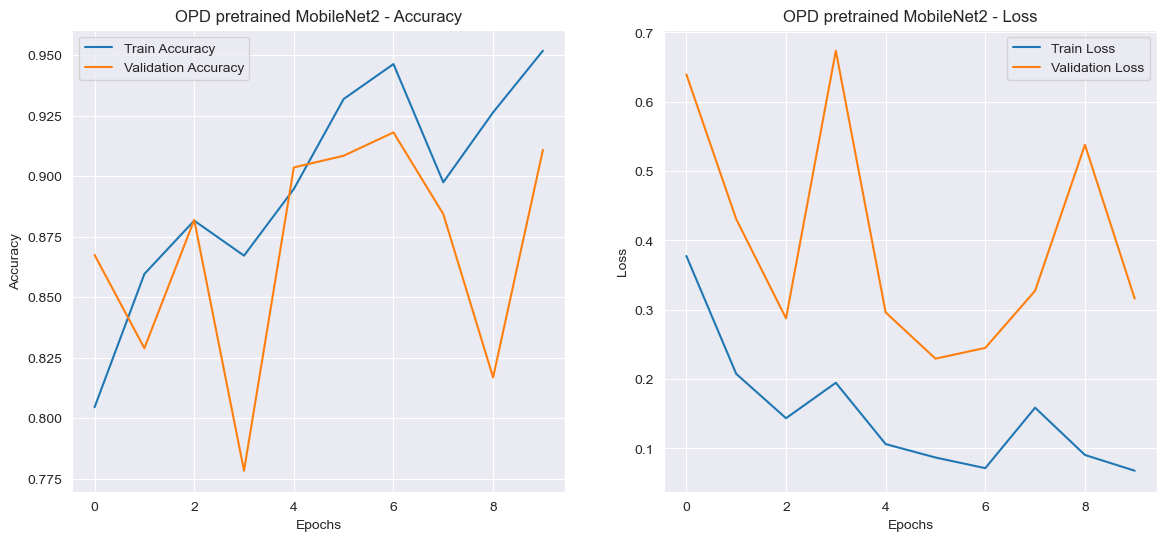

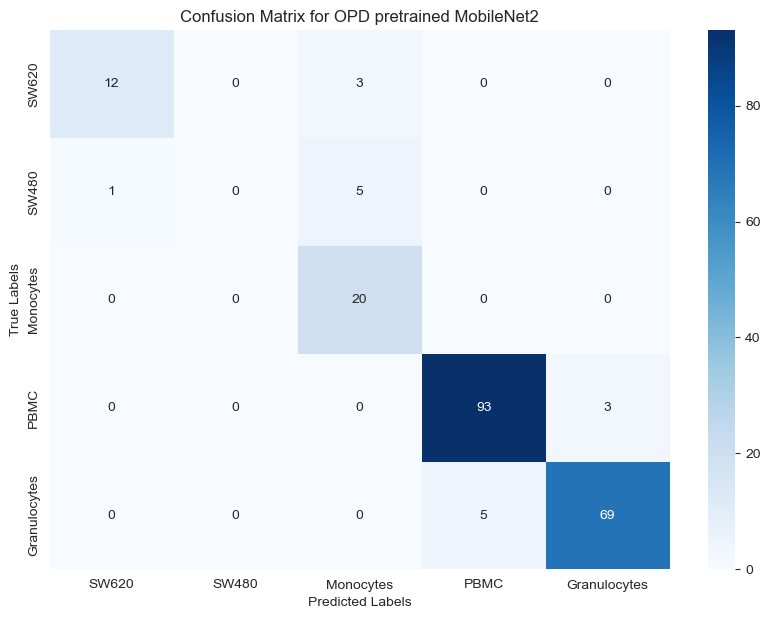

Processing Time: 6.45 seconds


In [29]:
# Evaluate the model
accuracy, precision, recall, f1, conf_matrix, processing_time = evaluate_model(trained_model, test_loader)
    
print(f"Model:Pretrained MobileNetV2 on OPD images")
print(f"Final Training Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
plot_training_history(history, 'OPD pretrained MobileNet2')
plot_confusion_matrix(conf_matrix, class_names, title=f'Confusion Matrix for OPD pretrained MobileNet2')
print(f"Processing Time: {processing_time:.2f} seconds")



In [30]:
# Save the model
torch.save(trained_model.state_dict(), 'OPD_pretrained_mobilenetV2.pth')


Same but with different learning rate

In [31]:
# Train the model
trained_model, history = train_model(model, train_loader, val_loader, num_epochs=10, weights=weights, lr=0.0001)

Epoch 1/10, Train Loss: 0.0392, Train Accuracy: 0.9642, Val Loss: 0.2100, Val Accuracy: 0.9301
Epoch 2/10, Train Loss: 0.0318, Train Accuracy: 0.9677, Val Loss: 0.2274, Val Accuracy: 0.9205
Epoch 3/10, Train Loss: 0.0257, Train Accuracy: 0.9725, Val Loss: 0.2398, Val Accuracy: 0.9205
Epoch 4/10, Train Loss: 0.0252, Train Accuracy: 0.9704, Val Loss: 0.2472, Val Accuracy: 0.9157
Epoch 5/10, Train Loss: 0.0206, Train Accuracy: 0.9732, Val Loss: 0.2201, Val Accuracy: 0.9205
Epoch 6/10, Train Loss: 0.0143, Train Accuracy: 0.9732, Val Loss: 0.2060, Val Accuracy: 0.9253
Epoch 7/10, Train Loss: 0.0122, Train Accuracy: 0.9752, Val Loss: 0.2313, Val Accuracy: 0.9181
Epoch 8/10, Train Loss: 0.0088, Train Accuracy: 0.9849, Val Loss: 0.2400, Val Accuracy: 0.9205
Epoch 9/10, Train Loss: 0.0111, Train Accuracy: 0.9862, Val Loss: 0.2197, Val Accuracy: 0.9277
Epoch 10/10, Train Loss: 0.0075, Train Accuracy: 0.9897, Val Loss: 0.2049, Val Accuracy: 0.9349
Finished Training


In [34]:
torch.save(trained_model.state_dict(), 'saved models/OPD_pretrained_mobilenetV2_lr2.pth')


Model:Pretrained MobileNetV2 on OPD images
Final Training Loss: 0.0075
Final Validation Loss: 0.2049
Accuracy: 0.9147
Precision: 0.9097
Recall: 0.9147
F1 Score: 0.9087


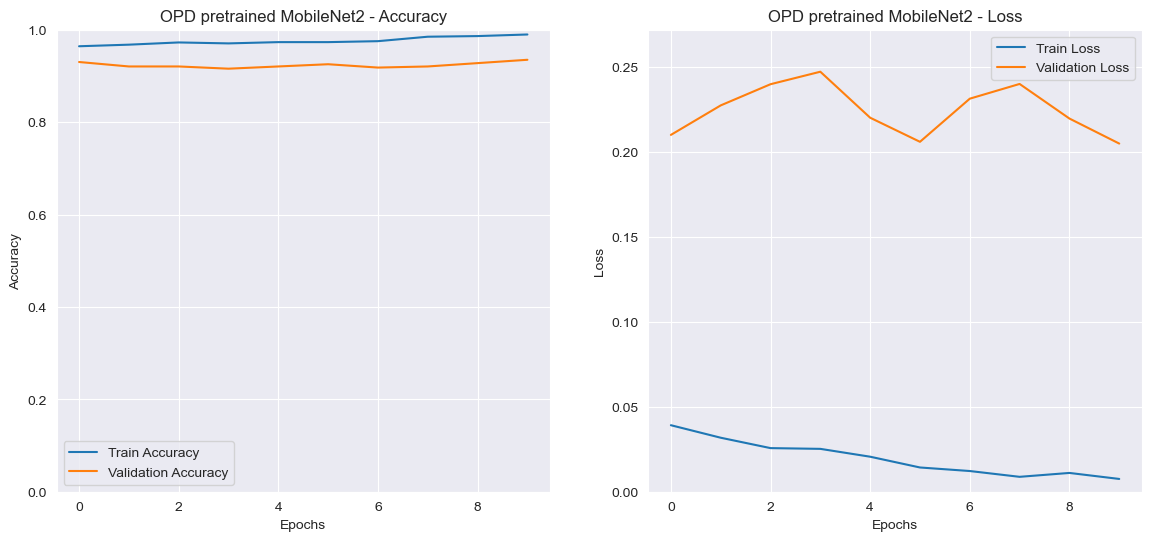

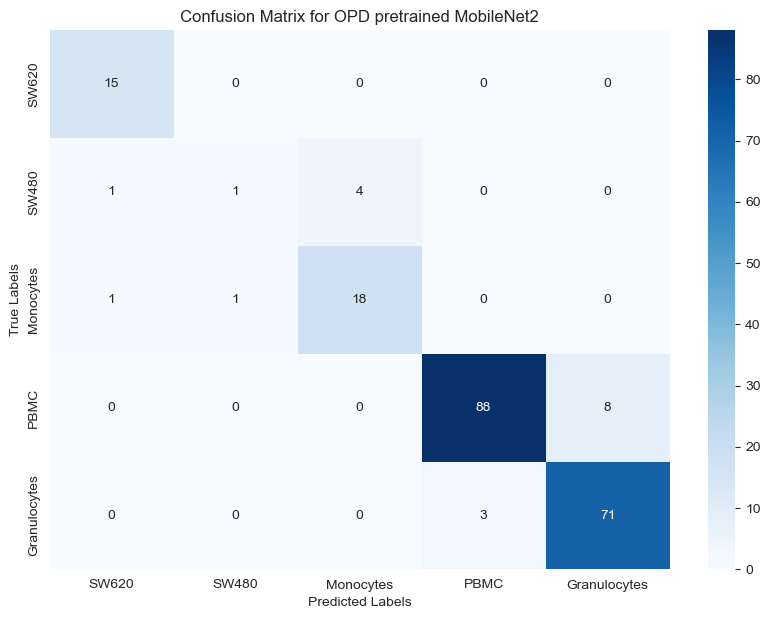

Processing Time per image: 0.03 seconds


In [40]:
# Evaluate the model
accuracy, precision, recall, f1, conf_matrix, processing_time = evaluate_model(trained_model, test_loader)

print(f"Model:Pretrained MobileNetV2 on OPD images")
print(f"Final Training Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
plot_training_history(history, 'OPD pretrained MobileNet2')
plot_confusion_matrix(conf_matrix, class_names, title=f'Confusion Matrix for OPD pretrained MobileNet2')
num_images = len(test_loader.dataset)
average_processing_time = processing_time / num_images
print(f"Processing Time per image: {average_processing_time:.2f} seconds")


In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model
def load_mobilenet(num_classes=5):
    model = models.mobilenet_v2(weights = None)
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

pth_file_path =  r'saved models/OPD_pretrained_mobilenetV2_lr2.pth'
model = load_mobilenet(num_classes=5)
pretrained_dict = torch.load(pth_file_path)
model_dict = model.state_dict()
pretrained_conv1_weight = pretrained_dict['features.0.0.weight']
pretrained_conv1_weight_mean = pretrained_conv1_weight.mean(dim=1, keepdim=True)
pretrained_dict['features.0.0.weight'] = pretrained_conv1_weight_mean
pretrained_dict = {k: v for k, v in pretrained_dict.items() if 'classifier.1' not in k}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [103]:
trained_model, history = train_model(model, train_loader, val_loader, num_epochs=20, weights=weights, lr=2.2492038172386544e-05)



Epoch 1/20, Train Loss: 1.3589, Train Accuracy: 0.3820, Val Loss: 1.0328, Val Accuracy: 0.8699
Epoch 2/20, Train Loss: 0.6739, Train Accuracy: 0.8933, Val Loss: 0.5356, Val Accuracy: 0.8723
Epoch 3/20, Train Loss: 0.3487, Train Accuracy: 0.9284, Val Loss: 0.3767, Val Accuracy: 0.9181
Epoch 4/20, Train Loss: 0.2271, Train Accuracy: 0.9670, Val Loss: 0.2854, Val Accuracy: 0.9229
Epoch 5/20, Train Loss: 0.1798, Train Accuracy: 0.9718, Val Loss: 0.2437, Val Accuracy: 0.9277
Epoch 6/20, Train Loss: 0.1315, Train Accuracy: 0.9732, Val Loss: 0.2123, Val Accuracy: 0.9301
Epoch 7/20, Train Loss: 0.1134, Train Accuracy: 0.9738, Val Loss: 0.2032, Val Accuracy: 0.9277
Epoch 8/20, Train Loss: 0.0883, Train Accuracy: 0.9738, Val Loss: 0.1904, Val Accuracy: 0.9325
Epoch 9/20, Train Loss: 0.0888, Train Accuracy: 0.9725, Val Loss: 0.1848, Val Accuracy: 0.9349
Epoch 10/20, Train Loss: 0.0705, Train Accuracy: 0.9745, Val Loss: 0.1786, Val Accuracy: 0.9325
Epoch 11/20, Train Loss: 0.0625, Train Accuracy: 

In [104]:
torch.save(trained_model.state_dict(), 'saved models/OPD_pretrained_mobilenetV2_tuned.pth')

Model:Pretrained MobileNetV2 on OPD images
Final Training Loss: 0.0248
Final Validation Loss: 0.1793
Accuracy: 0.9147
Precision: 0.9110
Recall: 0.9147
F1 Score: 0.9115


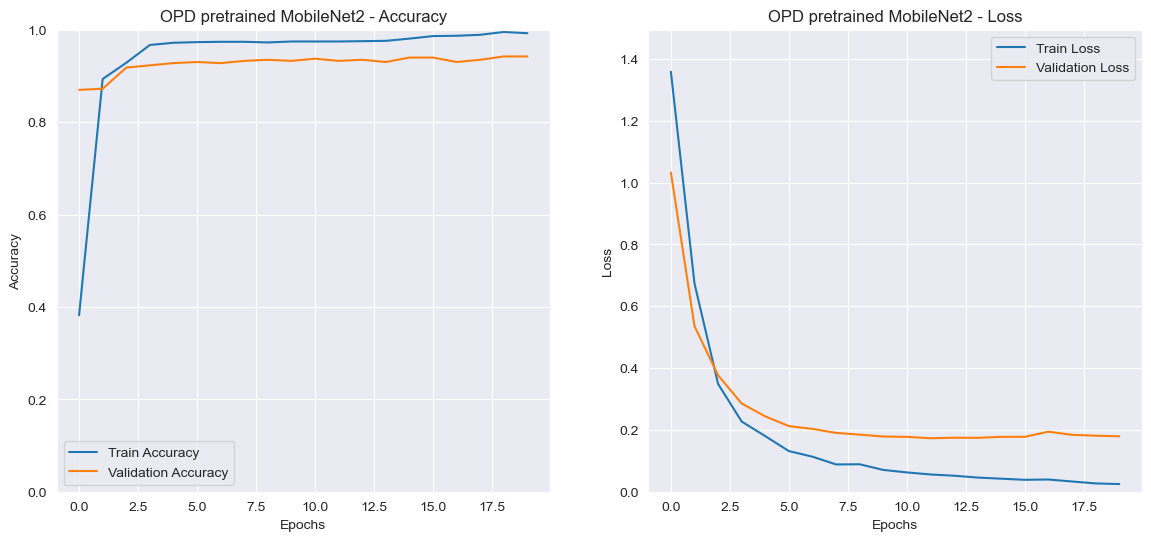

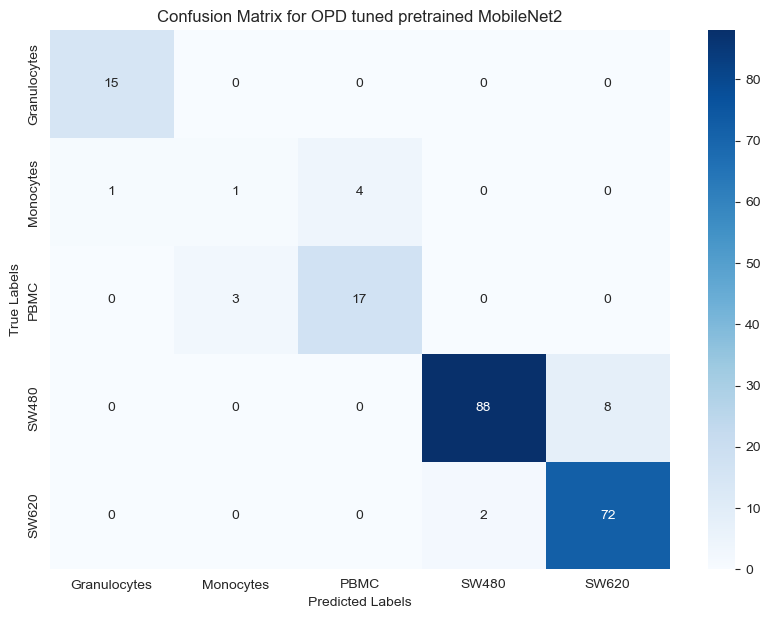

Processing Time per image: 0.02 seconds


In [105]:
# Evaluate the model
accuracy, precision, recall, f1, conf_matrix, processing_time = evaluate_model(trained_model, test_loader)

print(f"Model:Pretrained MobileNetV2 on OPD images")
print(f"Final Training Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
plot_training_history(history, 'OPD pretrained MobileNet2')
plot_confusion_matrix(conf_matrix, class_names, title=f'Confusion Matrix for OPD tuned pretrained MobileNet2')
num_images = len(test_loader.dataset)
average_processing_time = processing_time / num_images
print(f"Processing Time per image: {average_processing_time:.2f} seconds")

Dino V2 model 

In [ ]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

In [48]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Resize images
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [50]:
train_dataset_Dino = datasets.ImageFolder(root=f'{data_dir}/train', transform=transform)
val_dataset_Dino = datasets.ImageFolder(root=f'{data_dir}/val', transform=transform)
test_dataset_Dino = datasets.ImageFolder(root=f'{data_dir}/test', transform=transform)

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset_Dino, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset_Dino, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset_Dino, batch_size=32, shuffle=False)

class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = dinov2_vits14
        self.classifier = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Linear(256, 5)
        )
    
    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        return x

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DinoVisionTransformerClassifier()
Dino_model = model.to(device)
model_name = 'DinoV2'
weights = torch.tensor([1/731, 1/958, 1/53, 1/195, 1/142], dtype=torch.float32)

# Train the model
trained_model, history= train_model(Dino_model, train_loader, val_loader, num_epochs=10,weights=weights,lr=0.001)



Epoch 1/10, Train Loss: 1.3668, Train Accuracy: 0.4095, Val Loss: 1.3723, Val Accuracy: 0.3663
Epoch 2/10, Train Loss: 1.1000, Train Accuracy: 0.4646, Val Loss: 1.1393, Val Accuracy: 0.6072
Epoch 3/10, Train Loss: 0.9263, Train Accuracy: 0.4652, Val Loss: 0.9894, Val Accuracy: 0.6000
Epoch 4/10, Train Loss: 0.8735, Train Accuracy: 0.5024, Val Loss: 0.9721, Val Accuracy: 0.6024
Epoch 5/10, Train Loss: 0.7071, Train Accuracy: 0.5623, Val Loss: 1.5714, Val Accuracy: 0.2916
Epoch 6/10, Train Loss: 0.6848, Train Accuracy: 0.5692, Val Loss: 1.0379, Val Accuracy: 0.5229
Epoch 7/10, Train Loss: 0.6575, Train Accuracy: 0.5217, Val Loss: 0.7993, Val Accuracy: 0.5663
Epoch 8/10, Train Loss: 0.5930, Train Accuracy: 0.5506, Val Loss: 0.8063, Val Accuracy: 0.6337
Epoch 9/10, Train Loss: 0.6588, Train Accuracy: 0.5361, Val Loss: 0.9787, Val Accuracy: 0.4289
Epoch 10/10, Train Loss: 0.6390, Train Accuracy: 0.5134, Val Loss: 0.8093, Val Accuracy: 0.6289
Finished Training


In [55]:
torch.save(trained_model.state_dict(), 'Dino V2 model.pth')


Model:Pretrained MobileNetV2 on OPD images
Final Training Loss: 0.6390
Final Validation Loss: 0.8093
Accuracy: 0.6493
Precision: 0.5953
Recall: 0.6493
F1 Score: 0.6032


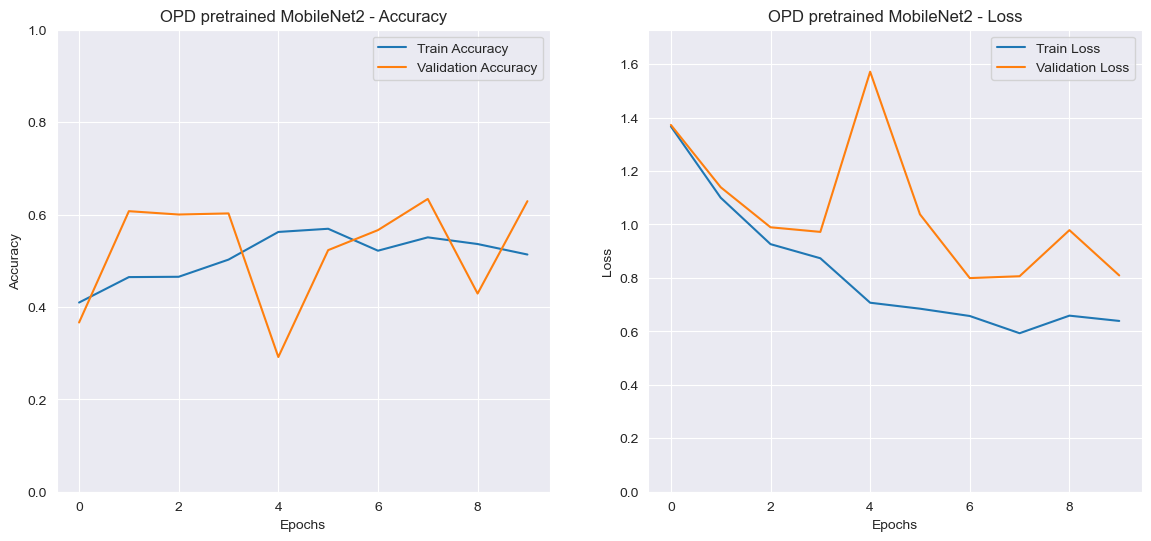

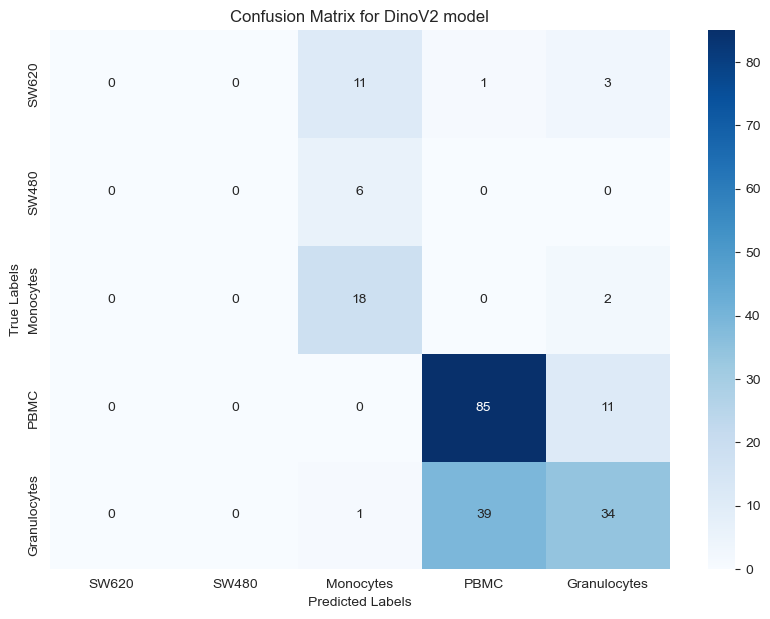

Processing Time per image: 0.10 seconds


In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate the model
accuracy, precision, recall, f1, conf_matrix, processing_time = evaluate_model(trained_model, test_loader)

print(f"Model:Pretrained MobileNetV2 on OPD images")
print(f"Final Training Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
plot_training_history(history, 'OPD pretrained MobileNet2')
plot_confusion_matrix(conf_matrix, class_names, title=f'Confusion Matrix for DinoV2 model')
num_images = len(test_loader.dataset)
average_processing_time = processing_time / num_images
print(f"Processing Time per image: {average_processing_time:.2f} seconds")

Hyperparameter tuning to DinoV2 model

In [62]:
def objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])


    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    train_loader = torch.utils.data.DataLoader(train_dataset_Dino, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset_Dino, batch_size=batch_size, shuffle=False)

    weights = torch.tensor([1/731, 1/958, 1/53, 1/195, 1/142], dtype=torch.float32).to(device)
    
    # Train the model
    trained_model, history = train_model(model, train_loader, val_loader, num_epochs=10, weights=weights, lr=lr)
    
    accuracy, precision, recall, f1, conf_matrix, processing_time = evaluate_model(trained_model, val_loader)
    
    return accuracy

study_name = "hyperparameter_study_DinoV2" 
study = optuna.create_study(direction='maximize',study_name=study_name) 

study.optimize(objective, n_trials=10)  

print("Best hyperparameters found by Optuna:")
print(study.best_params)

print(f"Best validation accuracy: {study.best_value:.4f}")

[I 2024-09-18 18:59:41,366] A new study created in memory with name: hyperparameter_study_DinoV2


Epoch 1/10, Train Loss: 1.4063, Train Accuracy: 0.3978, Val Loss: 1.2099, Val Accuracy: 0.3518
Epoch 2/10, Train Loss: 1.0074, Train Accuracy: 0.4646, Val Loss: 1.0383, Val Accuracy: 0.5614
Epoch 3/10, Train Loss: 0.8314, Train Accuracy: 0.5313, Val Loss: 0.9180, Val Accuracy: 0.5494
Epoch 4/10, Train Loss: 0.7626, Train Accuracy: 0.4749, Val Loss: 0.8788, Val Accuracy: 0.5373
Epoch 5/10, Train Loss: 0.7681, Train Accuracy: 0.5348, Val Loss: 0.9088, Val Accuracy: 0.5759
Epoch 6/10, Train Loss: 0.6968, Train Accuracy: 0.5052, Val Loss: 0.8754, Val Accuracy: 0.5398
Epoch 7/10, Train Loss: 0.6927, Train Accuracy: 0.5520, Val Loss: 0.8781, Val Accuracy: 0.5880
Epoch 8/10, Train Loss: 0.6584, Train Accuracy: 0.5465, Val Loss: 0.8324, Val Accuracy: 0.5422
Epoch 9/10, Train Loss: 0.6824, Train Accuracy: 0.5141, Val Loss: 0.9179, Val Accuracy: 0.5614
Epoch 10/10, Train Loss: 0.6770, Train Accuracy: 0.5754, Val Loss: 0.8367, Val Accuracy: 0.6265
Finished Training


[I 2024-09-18 21:06:35,563] Trial 0 finished with value: 0.6216867469879518 and parameters: {'lr': 0.001790580801115008, 'weight_decay': 1.7157781290796153e-05, 'batch_size': 16}. Best is trial 0 with value: 0.6216867469879518.


Epoch 1/10, Train Loss: 0.6302, Train Accuracy: 0.6063, Val Loss: 0.8404, Val Accuracy: 0.6434
Epoch 2/10, Train Loss: 0.6246, Train Accuracy: 0.6098, Val Loss: 0.8494, Val Accuracy: 0.6410
Epoch 3/10, Train Loss: 0.5996, Train Accuracy: 0.6215, Val Loss: 0.8160, Val Accuracy: 0.6193
Epoch 4/10, Train Loss: 0.5762, Train Accuracy: 0.6242, Val Loss: 0.8015, Val Accuracy: 0.6217
Epoch 5/10, Train Loss: 0.5861, Train Accuracy: 0.6277, Val Loss: 0.8264, Val Accuracy: 0.6072
Epoch 6/10, Train Loss: 0.5764, Train Accuracy: 0.6277, Val Loss: 0.8390, Val Accuracy: 0.6313
Epoch 7/10, Train Loss: 0.5776, Train Accuracy: 0.6414, Val Loss: 0.7980, Val Accuracy: 0.6578
Epoch 8/10, Train Loss: 0.5895, Train Accuracy: 0.6401, Val Loss: 0.8316, Val Accuracy: 0.6627
Epoch 9/10, Train Loss: 0.5823, Train Accuracy: 0.6311, Val Loss: 0.8292, Val Accuracy: 0.5976
Epoch 10/10, Train Loss: 0.5728, Train Accuracy: 0.6490, Val Loss: 0.8196, Val Accuracy: 0.6289
Finished Training


[I 2024-09-18 23:16:21,049] Trial 1 finished with value: 0.6265060240963856 and parameters: {'lr': 2.3768876478548875e-05, 'weight_decay': 1.7133357729539645e-05, 'batch_size': 16}. Best is trial 1 with value: 0.6265060240963856.


Epoch 1/10, Train Loss: 0.6280, Train Accuracy: 0.5630, Val Loss: 0.9104, Val Accuracy: 0.4699
Epoch 2/10, Train Loss: 0.6057, Train Accuracy: 0.5774, Val Loss: 0.7789, Val Accuracy: 0.6241
Epoch 3/10, Train Loss: 0.6088, Train Accuracy: 0.5664, Val Loss: 0.8052, Val Accuracy: 0.5904
Epoch 4/10, Train Loss: 0.5752, Train Accuracy: 0.6180, Val Loss: 0.9012, Val Accuracy: 0.5663
Epoch 5/10, Train Loss: 0.6581, Train Accuracy: 0.5699, Val Loss: 0.8038, Val Accuracy: 0.6506
Epoch 6/10, Train Loss: 0.6547, Train Accuracy: 0.6022, Val Loss: 0.8036, Val Accuracy: 0.6289
Epoch 7/10, Train Loss: 0.6026, Train Accuracy: 0.6029, Val Loss: 0.8143, Val Accuracy: 0.5928
Epoch 8/10, Train Loss: 0.6051, Train Accuracy: 0.6077, Val Loss: 0.9079, Val Accuracy: 0.5181
Epoch 9/10, Train Loss: 0.6038, Train Accuracy: 0.6173, Val Loss: 0.7676, Val Accuracy: 0.6217
Epoch 10/10, Train Loss: 0.5655, Train Accuracy: 0.6091, Val Loss: 0.7568, Val Accuracy: 0.6506
Finished Training


[I 2024-09-19 01:01:13,614] Trial 2 finished with value: 0.655421686746988 and parameters: {'lr': 0.0005312657359693227, 'weight_decay': 1.6373329304649504e-06, 'batch_size': 16}. Best is trial 2 with value: 0.655421686746988.


Epoch 1/10, Train Loss: 0.5809, Train Accuracy: 0.6153, Val Loss: 0.7848, Val Accuracy: 0.6096
Epoch 2/10, Train Loss: 0.6241, Train Accuracy: 0.6070, Val Loss: 0.8277, Val Accuracy: 0.5831
Epoch 3/10, Train Loss: 0.6276, Train Accuracy: 0.5733, Val Loss: 0.8508, Val Accuracy: 0.5880
Epoch 4/10, Train Loss: 0.6067, Train Accuracy: 0.5864, Val Loss: 0.8479, Val Accuracy: 0.5831
Epoch 5/10, Train Loss: 0.5889, Train Accuracy: 0.6050, Val Loss: 0.8510, Val Accuracy: 0.5831
Epoch 6/10, Train Loss: 0.5804, Train Accuracy: 0.5946, Val Loss: 0.8070, Val Accuracy: 0.6361
Epoch 7/10, Train Loss: 0.6357, Train Accuracy: 0.5919, Val Loss: 0.8032, Val Accuracy: 0.6217
Epoch 8/10, Train Loss: 0.5881, Train Accuracy: 0.6201, Val Loss: 0.7895, Val Accuracy: 0.6217
Epoch 9/10, Train Loss: 0.5767, Train Accuracy: 0.6008, Val Loss: 0.7745, Val Accuracy: 0.6482
Epoch 10/10, Train Loss: 0.5855, Train Accuracy: 0.6215, Val Loss: 0.8048, Val Accuracy: 0.6024
Finished Training


[I 2024-09-19 02:55:22,227] Trial 3 finished with value: 0.6120481927710844 and parameters: {'lr': 9.852353831781241e-05, 'weight_decay': 4.0108638189197794e-05, 'batch_size': 16}. Best is trial 2 with value: 0.655421686746988.


Epoch 1/10, Train Loss: 0.5320, Train Accuracy: 0.6538, Val Loss: 0.6270, Val Accuracy: 0.6482
Epoch 2/10, Train Loss: 0.5555, Train Accuracy: 0.6483, Val Loss: 0.6126, Val Accuracy: 0.5542
Epoch 3/10, Train Loss: 0.5116, Train Accuracy: 0.6538, Val Loss: 0.5118, Val Accuracy: 0.6675
Epoch 4/10, Train Loss: 0.5209, Train Accuracy: 0.6696, Val Loss: 0.5418, Val Accuracy: 0.6916
Epoch 5/10, Train Loss: 0.4914, Train Accuracy: 0.6772, Val Loss: 0.5683, Val Accuracy: 0.5928
Epoch 6/10, Train Loss: 0.5204, Train Accuracy: 0.6676, Val Loss: 0.5188, Val Accuracy: 0.6843
Epoch 7/10, Train Loss: 0.5224, Train Accuracy: 0.6690, Val Loss: 0.5870, Val Accuracy: 0.5904
Epoch 8/10, Train Loss: 0.5180, Train Accuracy: 0.6827, Val Loss: 0.5596, Val Accuracy: 0.6530
Epoch 9/10, Train Loss: 0.4999, Train Accuracy: 0.6772, Val Loss: 0.5000, Val Accuracy: 0.6940
Epoch 10/10, Train Loss: 0.5240, Train Accuracy: 0.6676, Val Loss: 0.5675, Val Accuracy: 0.5976
Finished Training


[I 2024-09-19 04:18:39,126] Trial 4 finished with value: 0.5614457831325301 and parameters: {'lr': 0.00034486759594385075, 'weight_decay': 0.00010250964346824757, 'batch_size': 64}. Best is trial 2 with value: 0.655421686746988.


Epoch 1/10, Train Loss: 0.5258, Train Accuracy: 0.6476, Val Loss: 0.5485, Val Accuracy: 0.6699
Epoch 2/10, Train Loss: 0.5365, Train Accuracy: 0.6380, Val Loss: 0.6054, Val Accuracy: 0.5831
Epoch 3/10, Train Loss: 0.5124, Train Accuracy: 0.6621, Val Loss: 0.5318, Val Accuracy: 0.6843
Epoch 4/10, Train Loss: 0.5308, Train Accuracy: 0.6834, Val Loss: 0.5870, Val Accuracy: 0.5880
Epoch 5/10, Train Loss: 0.5201, Train Accuracy: 0.6504, Val Loss: 0.5220, Val Accuracy: 0.6675
Epoch 6/10, Train Loss: 0.4978, Train Accuracy: 0.6752, Val Loss: 0.5001, Val Accuracy: 0.6867
Epoch 7/10, Train Loss: 0.4978, Train Accuracy: 0.6917, Val Loss: 0.5047, Val Accuracy: 0.6554
Epoch 8/10, Train Loss: 0.4832, Train Accuracy: 0.6807, Val Loss: 0.5184, Val Accuracy: 0.6867
Epoch 9/10, Train Loss: 0.4994, Train Accuracy: 0.6724, Val Loss: 0.5500, Val Accuracy: 0.6410
Epoch 10/10, Train Loss: 0.6098, Train Accuracy: 0.6717, Val Loss: 0.5364, Val Accuracy: 0.6675
Finished Training


[I 2024-09-19 05:45:10,007] Trial 5 finished with value: 0.655421686746988 and parameters: {'lr': 0.0002719825147150129, 'weight_decay': 6.099569751696221e-05, 'batch_size': 64}. Best is trial 2 with value: 0.655421686746988.


Epoch 1/10, Train Loss: 0.5322, Train Accuracy: 0.6999, Val Loss: 0.7589, Val Accuracy: 0.6916
Epoch 2/10, Train Loss: 0.4900, Train Accuracy: 0.7220, Val Loss: 0.7057, Val Accuracy: 0.6843
Epoch 3/10, Train Loss: 0.4822, Train Accuracy: 0.7041, Val Loss: 0.7374, Val Accuracy: 0.6627
Epoch 4/10, Train Loss: 0.4739, Train Accuracy: 0.7013, Val Loss: 0.7103, Val Accuracy: 0.6916
Epoch 5/10, Train Loss: 0.5000, Train Accuracy: 0.6979, Val Loss: 0.7313, Val Accuracy: 0.6867
Epoch 6/10, Train Loss: 0.4910, Train Accuracy: 0.7013, Val Loss: 0.7200, Val Accuracy: 0.6771
Epoch 7/10, Train Loss: 0.4924, Train Accuracy: 0.7041, Val Loss: 0.7066, Val Accuracy: 0.6699
Epoch 8/10, Train Loss: 0.4934, Train Accuracy: 0.6917, Val Loss: 0.7049, Val Accuracy: 0.6867
Epoch 9/10, Train Loss: 0.4681, Train Accuracy: 0.7096, Val Loss: 0.6782, Val Accuracy: 0.7036
Epoch 10/10, Train Loss: 0.4573, Train Accuracy: 0.7123, Val Loss: 0.6965, Val Accuracy: 0.6988
Finished Training


[I 2024-09-19 07:29:51,921] Trial 6 finished with value: 0.691566265060241 and parameters: {'lr': 1.501572991375157e-05, 'weight_decay': 1.916118591623786e-06, 'batch_size': 16}. Best is trial 6 with value: 0.691566265060241.


Epoch 1/10, Train Loss: 0.6367, Train Accuracy: 0.5451, Val Loss: 0.7814, Val Accuracy: 0.6072
Epoch 2/10, Train Loss: 0.6548, Train Accuracy: 0.5382, Val Loss: 0.7770, Val Accuracy: 0.6602
Epoch 3/10, Train Loss: 0.5738, Train Accuracy: 0.6146, Val Loss: 0.7775, Val Accuracy: 0.6410
Epoch 4/10, Train Loss: 0.5854, Train Accuracy: 0.6084, Val Loss: 0.8388, Val Accuracy: 0.4940
Epoch 5/10, Train Loss: 0.7357, Train Accuracy: 0.5747, Val Loss: 1.0267, Val Accuracy: 0.4337
Epoch 6/10, Train Loss: 0.6716, Train Accuracy: 0.5575, Val Loss: 0.9303, Val Accuracy: 0.6024
Epoch 7/10, Train Loss: 0.6280, Train Accuracy: 0.5685, Val Loss: 0.8193, Val Accuracy: 0.6265
Epoch 8/10, Train Loss: 0.5921, Train Accuracy: 0.6173, Val Loss: 0.9008, Val Accuracy: 0.6120
Epoch 9/10, Train Loss: 0.5917, Train Accuracy: 0.6531, Val Loss: 0.7689, Val Accuracy: 0.6578
Epoch 10/10, Train Loss: 0.5521, Train Accuracy: 0.6545, Val Loss: 0.8375, Val Accuracy: 0.6386
Finished Training


[I 2024-09-19 09:12:41,233] Trial 7 finished with value: 0.6240963855421687 and parameters: {'lr': 0.0014250758384653241, 'weight_decay': 2.299114656663904e-05, 'batch_size': 32}. Best is trial 6 with value: 0.691566265060241.


Epoch 1/10, Train Loss: 0.6016, Train Accuracy: 0.6566, Val Loss: 0.7949, Val Accuracy: 0.6747
Epoch 2/10, Train Loss: 0.5416, Train Accuracy: 0.6793, Val Loss: 0.7960, Val Accuracy: 0.6675
Epoch 3/10, Train Loss: 0.5351, Train Accuracy: 0.6738, Val Loss: 0.7878, Val Accuracy: 0.6289
Epoch 4/10, Train Loss: 0.5645, Train Accuracy: 0.6752, Val Loss: 0.7748, Val Accuracy: 0.6843
Epoch 5/10, Train Loss: 0.5110, Train Accuracy: 0.6875, Val Loss: 0.7311, Val Accuracy: 0.6892
Epoch 6/10, Train Loss: 0.5226, Train Accuracy: 0.6841, Val Loss: 0.7185, Val Accuracy: 0.6940
Epoch 7/10, Train Loss: 0.5771, Train Accuracy: 0.6869, Val Loss: 0.7709, Val Accuracy: 0.6627
Epoch 8/10, Train Loss: 0.5276, Train Accuracy: 0.6820, Val Loss: 0.7074, Val Accuracy: 0.7060
Epoch 9/10, Train Loss: 0.5085, Train Accuracy: 0.6820, Val Loss: 0.7377, Val Accuracy: 0.7012
Epoch 10/10, Train Loss: 0.5128, Train Accuracy: 0.6848, Val Loss: 0.7286, Val Accuracy: 0.6892
Finished Training


[I 2024-09-19 11:12:15,024] Trial 8 finished with value: 0.6771084337349398 and parameters: {'lr': 0.00020506680332354135, 'weight_decay': 6.207591302667897e-06, 'batch_size': 32}. Best is trial 6 with value: 0.691566265060241.


Epoch 1/10, Train Loss: 0.5256, Train Accuracy: 0.6951, Val Loss: 0.5334, Val Accuracy: 0.7012
Epoch 2/10, Train Loss: 0.5300, Train Accuracy: 0.6855, Val Loss: 0.5123, Val Accuracy: 0.7036
Epoch 3/10, Train Loss: 0.5055, Train Accuracy: 0.6862, Val Loss: 0.5111, Val Accuracy: 0.6964
Epoch 4/10, Train Loss: 0.4997, Train Accuracy: 0.6930, Val Loss: 0.4914, Val Accuracy: 0.7084
Epoch 5/10, Train Loss: 0.5056, Train Accuracy: 0.6986, Val Loss: 0.4979, Val Accuracy: 0.7036
Epoch 6/10, Train Loss: 0.4976, Train Accuracy: 0.7027, Val Loss: 0.5329, Val Accuracy: 0.6795
Epoch 7/10, Train Loss: 0.4818, Train Accuracy: 0.7027, Val Loss: 0.5806, Val Accuracy: 0.6361
Epoch 8/10, Train Loss: 0.4970, Train Accuracy: 0.6889, Val Loss: 0.4784, Val Accuracy: 0.7157
Epoch 9/10, Train Loss: 0.4702, Train Accuracy: 0.7130, Val Loss: 0.5090, Val Accuracy: 0.6940
Epoch 10/10, Train Loss: 0.5105, Train Accuracy: 0.7116, Val Loss: 0.5528, Val Accuracy: 0.6795
Finished Training


[I 2024-09-19 12:45:42,377] Trial 9 finished with value: 0.6939759036144578 and parameters: {'lr': 0.00016174398903378903, 'weight_decay': 0.0006684461695168065, 'batch_size': 64}. Best is trial 9 with value: 0.6939759036144578.


Epoch 1/10, Train Loss: 1.2302, Train Accuracy: 0.4226, Val Loss: 0.8752, Val Accuracy: 0.5518
Epoch 2/10, Train Loss: 0.9399, Train Accuracy: 0.5217, Val Loss: 0.8190, Val Accuracy: 0.5566
Epoch 3/10, Train Loss: 0.8823, Train Accuracy: 0.4907, Val Loss: 0.8594, Val Accuracy: 0.5542
Epoch 4/10, Train Loss: 0.9544, Train Accuracy: 0.4948, Val Loss: 0.9289, Val Accuracy: 0.5759
Epoch 5/10, Train Loss: 0.8625, Train Accuracy: 0.5465, Val Loss: 0.8367, Val Accuracy: 0.4651
Epoch 6/10, Train Loss: 0.8865, Train Accuracy: 0.4866, Val Loss: 1.2212, Val Accuracy: 0.4843
Epoch 7/10, Train Loss: 1.1921, Train Accuracy: 0.3558, Val Loss: 1.0855, Val Accuracy: 0.4843


[W 2024-09-19 13:59:58,523] Trial 10 failed with parameters: {'lr': 0.00797351181530047, 'weight_decay': 0.000701761653971104, 'batch_size': 64} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\edendotan\AppData\Local\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\edendotan\AppData\Local\Temp\ipykernel_28796\4292364275.py", line 15, in objective
    trained_model, history = train_model(model, train_loader, val_loader, num_epochs=10, weights=weights, lr=lr)
                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\edendotan\AppData\Local\Temp\ipykernel_28796\1219579733.py", line 20, in train_model
    loss.backward()
  File "C:\Users\edendotan\AppData\Local\anaconda3\Lib\site-packages\torch\_tensor.py", line 525, in backward
    torch.autograd.b

KeyboardInterrupt: 

Train best DinoV2 model on augmented data

In [63]:
weights = torch.tensor([1/731, 1/958, 1/212, 1/780, 1/568], dtype=torch.float32)

In [70]:
best_batch_size = 64
best_lr = 0.00016174398903378903

In [111]:
# Augmented data directory
data_dir = r'C:\Users\edendotan\PycharmProjects\DL_course_project\session number 3\Augmented data images'

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_aug_dataset_Dino = datasets.ImageFolder(train_dir, transform=transform)
val_aug_dataset_Dino = datasets.ImageFolder(val_dir, transform=transform)
test_aug_dataset_Dino = datasets.ImageFolder(test_dir, transform=transform)

# Define the DataLoader
train_loader = torch.utils.data.DataLoader(train_aug_dataset_Dino, batch_size=best_batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_aug_dataset_Dino, batch_size=best_batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_aug_dataset_Dino, batch_size=best_batch_size, shuffle=False)


In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DinoVisionTransformerClassifier()
Dino_model = model.to(device)
model_name = 'DinoV2'

# Train the model using the best hyperparameters
trained_model, history = train_model(model, train_loader, val_loader, num_epochs=20, weights=weights, lr=best_lr)


Epoch 1/20, Train Loss: 1.2279, Train Accuracy: 0.2469, Val Loss: 1.3830, Val Accuracy: 0.2431
Epoch 2/20, Train Loss: 1.1520, Train Accuracy: 0.2936, Val Loss: 1.3499, Val Accuracy: 0.3246
Epoch 3/20, Train Loss: 1.1067, Train Accuracy: 0.3530, Val Loss: 1.2847, Val Accuracy: 0.4492
Epoch 4/20, Train Loss: 1.0661, Train Accuracy: 0.4274, Val Loss: 1.2901, Val Accuracy: 0.3538
Epoch 5/20, Train Loss: 1.0437, Train Accuracy: 0.4252, Val Loss: 1.2963, Val Accuracy: 0.3969
Epoch 6/20, Train Loss: 1.0488, Train Accuracy: 0.4595, Val Loss: 1.2731, Val Accuracy: 0.4538
Epoch 7/20, Train Loss: 1.0401, Train Accuracy: 0.4551, Val Loss: 1.1711, Val Accuracy: 0.4954
Epoch 8/20, Train Loss: 1.0131, Train Accuracy: 0.4582, Val Loss: 1.2417, Val Accuracy: 0.4708
Epoch 9/20, Train Loss: 1.0154, Train Accuracy: 0.4551, Val Loss: 1.1553, Val Accuracy: 0.4831
Epoch 10/20, Train Loss: 0.9795, Train Accuracy: 0.4674, Val Loss: 1.1442, Val Accuracy: 0.5231
Epoch 11/20, Train Loss: 0.9822, Train Accuracy: 

RuntimeError: Parent directory C:\Users\edendotan\PycharmProjects\DL_cours_project\saved models does not exist.

In [73]:
# Save the trained model
model_save_path = r'C:\Users\edendotan\PycharmProjects\DL_course_project\session number 3\saved models\best_dino_v2_model.pth'
torch.save(trained_model.state_dict(), model_save_path)

In [74]:

# Evaluate the model
accuracy, precision, recall, f1, conf_matrix, processing_time = evaluate_model(trained_model, test_loader)


In [81]:
print(conf_matrix)

[[ 0  0 55  2  0]
 [ 0  0 21  1  0]
 [ 0  0 76  1  1]
 [ 0  0  4 81 11]
 [ 0  0 23 27 24]]


In [77]:
# saving
evaluation_metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Processing Time'],
    'Value': [accuracy, precision, recall, f1, processing_time]}
df_metrics = pd.DataFrame(evaluation_metrics)
excel_save_path = r'C:\Users\edendotan\PycharmProjects\DL_course_project\results\DinoV2_evaluation_metrics.xlsx'
df_metrics.to_excel(excel_save_path, index=False)

print(f"Evaluation metrics saved to {excel_save_path}")

Evaluation metrics saved to C:\Users\edendotan\PycharmProjects\DL_cours_project\results\DinoV2_evaluation_metrics.xlsx


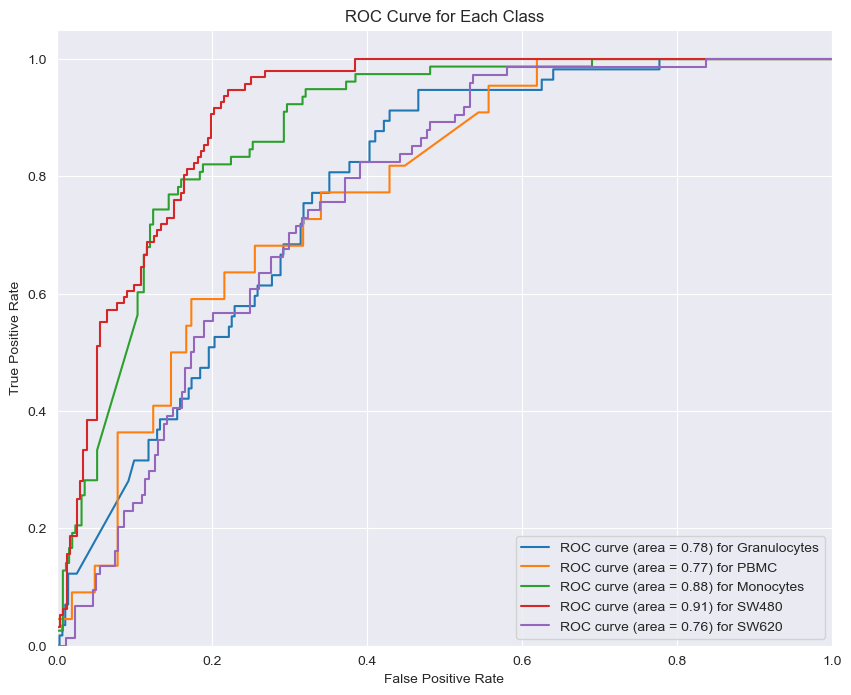

ROC curve saved to C:\Users\edendotan\PycharmProjects\DL_cours_project\results\best_DinoV2_roc_curve.png


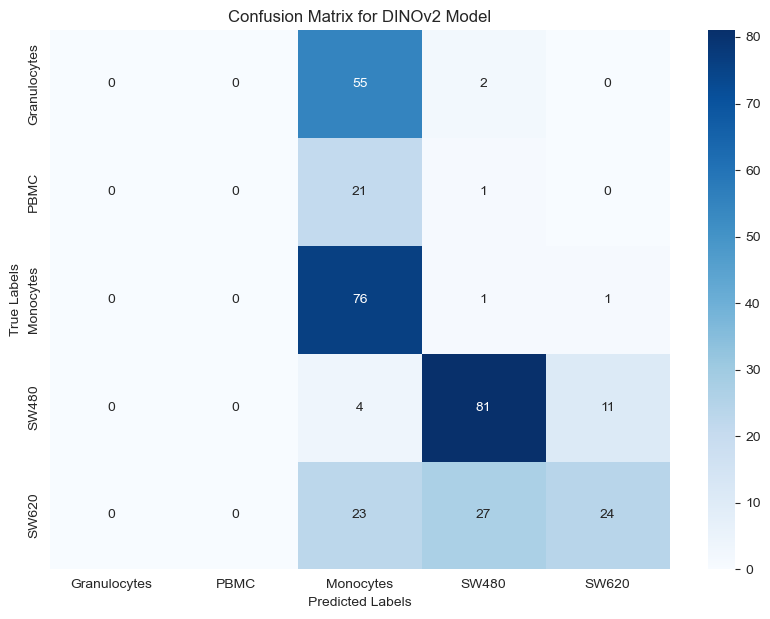

In [91]:
def plot_and_save_roc_curve(model, test_loader, class_names, save_path):
    all_labels = []
    all_probs = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())
    
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(np.array(all_labels) == i, np.array(all_probs)[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for {class_name}')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc='lower right')
    
    plt.savefig(save_path)
    plt.show()

roc_save_path = r'C:\Users\edendotan\PycharmProjects\DL_course_project\results\best_DinoV2_roc_curve.png'
plot_and_save_roc_curve(trained_model, test_loader, class_names, roc_save_path)

print(f"ROC curve saved to {roc_save_path}")


plot_confusion_matrix(conf_matrix, class_names, title='Confusion Matrix for DINOv2 Model')
plt.show()




Re-plotting confusion matrix (fix indexes mistake)

In [113]:
model = DinoVisionTransformerClassifier()
model.load_state_dict(torch.load(r'C:\Users\edendotan\PycharmProjects\DL_course_project\session number 3\saved models\best_dino_v2_model.pth'))
model.to(device)
model.eval()
accuracy, precision, recall, f1, conf_matrix, processing_time= evaluate_model(model, test_loader)

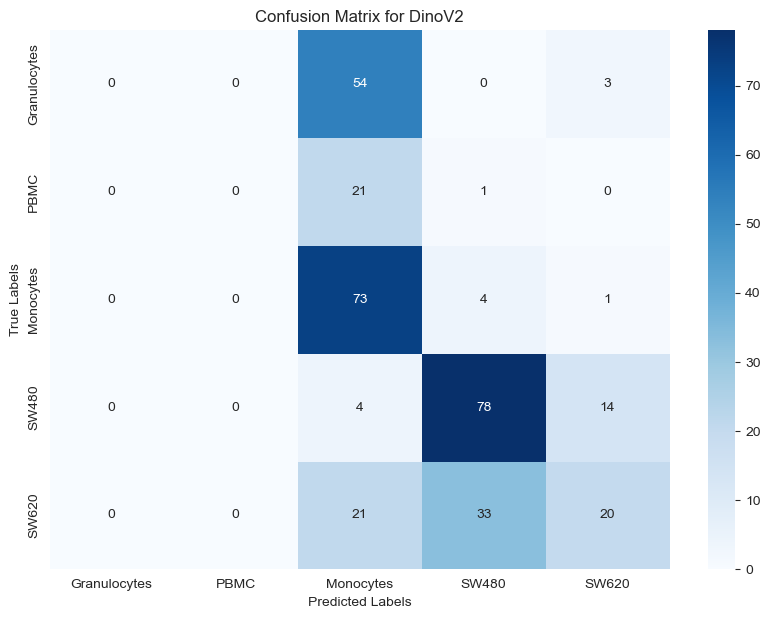

In [114]:
plot_confusion_matrix(conf_matrix, class_names, title=f'Confusion Matrix for DinoV2')
